# SF Crime Analysis: Forecasting

### Data-x (IEOR 135)


In [1]:
# Load required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 
from collections import Counter
%matplotlib inline

In [2]:
# Read in data
df1 = pd.read_csv('Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')

In [3]:
# Format date columns
df1['Date'] = pd.to_datetime(df1['Date'])
df1['Year-Month'] = df1['Date'].map(lambda x: '{year}-{month}'.format(year=x.year,
                                                              month=x.month,
                                                            day=x.day))
df1['Year'] = df1['Date'].dt.year.astype(int)
df1['Week_Number'] = df1['Date'].dt.week
df1['Month_Number'] = df1['Date'].dt.month

## Wordcloud of Top Crime

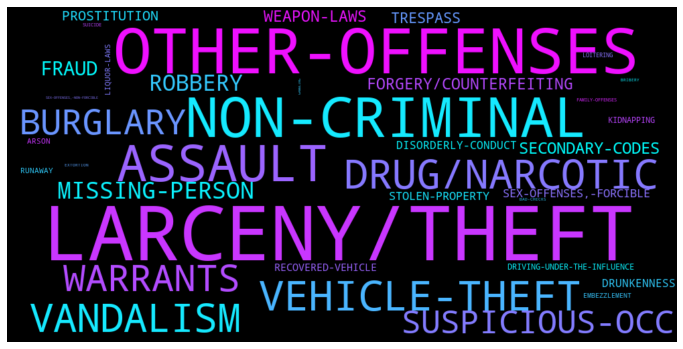

In [4]:
dic_freq = df1['Category'].str.replace(" ","-").str.split(expand=True).stack().value_counts().to_dict()
plt.figure(figsize = (12,10))
wordcloud = WordCloud(colormap="cool", background_color='black',width=1000, height=500).generate_from_frequencies(dic_freq)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

## Top 10 Crimes in SF

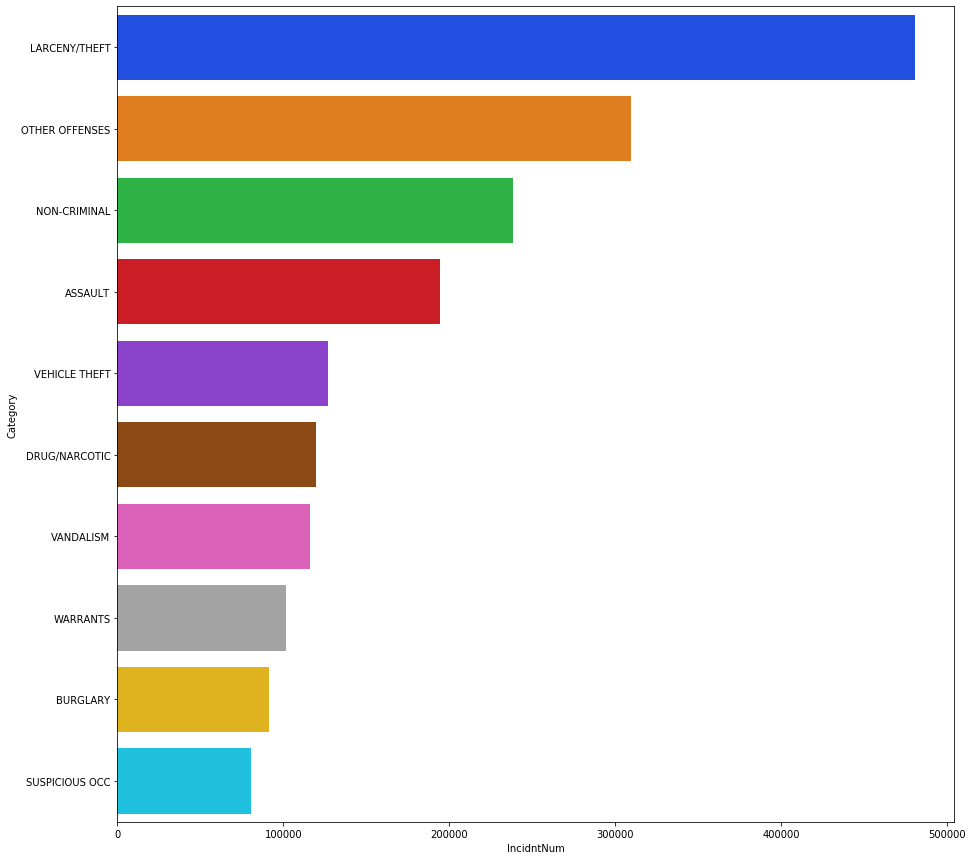

In [5]:
plt.rcParams['figure.figsize'] = (15, 15)
totalCrimes = df1.groupby('Category', as_index = False).count().sort_values(by = 'IncidntNum', ascending = False)

ax = sns.barplot(x="IncidntNum", y="Category", data=totalCrimes.head(10),palette="bright")

In [6]:
top10Crimes = list(totalCrimes.iloc[0:10,:2]['Category'])
print("Top 10 Crimes from 2003-2018 are: ")
[print("     " + str(c)) for c in top10Crimes];

Top 10 Crimes from 2003-2018 are: 
     LARCENY/THEFT
     OTHER OFFENSES
     NON-CRIMINAL
     ASSAULT
     VEHICLE THEFT
     DRUG/NARCOTIC
     VANDALISM
     WARRANTS
     BURGLARY
     SUSPICIOUS OCC


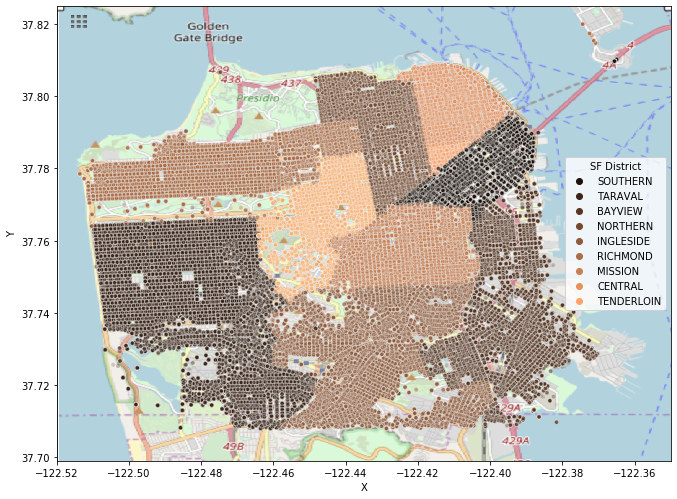

In [7]:
map_bound = ((-122.5200, -122.3500, 37.699, 37.8249))
basemap = plt.imread('sf1.png')
fig, ax = plt.subplots(figsize = (11,11))
ax.set_xlim(map_bound[0],map_bound[1])
ax.set_ylim(map_bound[2],map_bound[3])
plt.xlabel("Longitude")
plt.ylabel("Lattitude")
ax.imshow(basemap, zorder=0, extent = map_bound, aspect= 'equal');
sns.scatterplot(x='X', y='Y', data=df1[df1['Y']<40], hue='PdDistrict',
          palette='copper', size=.01, alpha=0.1, ax=ax)
ax.get_legend().remove()
ax.legend(ax.get_legend_handles_labels()[0][1:10], 
          ax.get_legend_handles_labels()[1][1:10], title='SF District')

Text(69.0, 0.5, '')

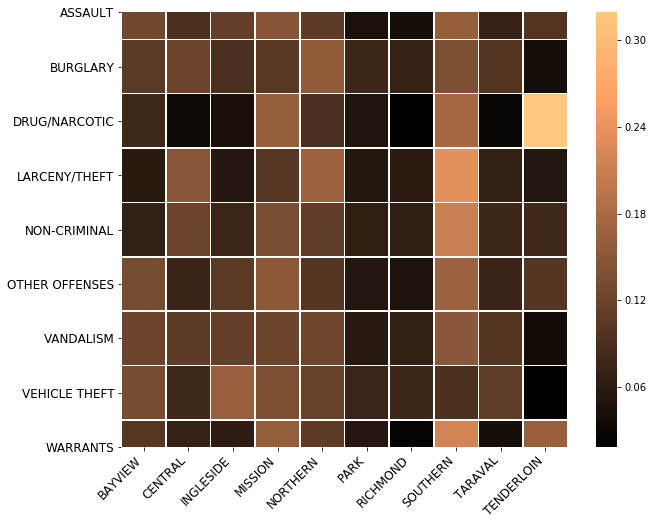

In [8]:
top_cat = df1['Category'].value_counts()[0:9].sort_values().index
top_commons = df1[df1['Category'].apply(lambda x: x in top_cat)]

cat_per_district = pd.crosstab(top_commons['Category'], top_commons['PdDistrict']) 
cat_per_district = cat_per_district.div(cat_per_district.sum(axis=1), axis=0)

fig = plt.figure(figsize=(10,8))
ax = sns.heatmap(cat_per_district,
                 cmap="copper", linewidths=.5)
plt.xticks(fontsize=12,rotation=45,ha='right')
plt.yticks(fontsize=12)
plt.xlabel("")
plt.ylabel("")

## Yearly Crime Patterns

In [9]:
crimebefore2017 = df1[df1['Year'] <= 2017]

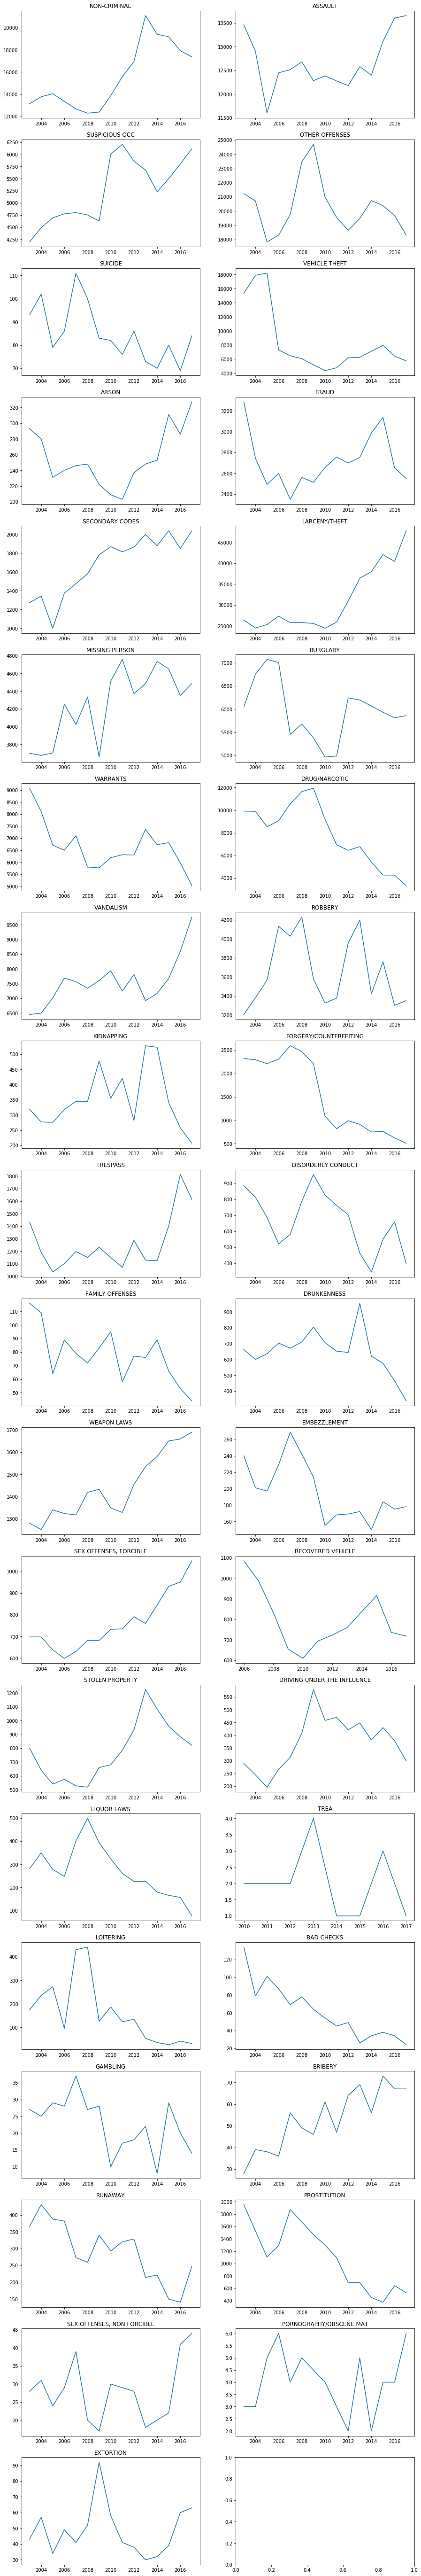

In [10]:
plt.rcParams['figure.figsize'] = (15, 5*20)
numCrimesType = 20 #df1.Category.unique().size
crimesType = list(df1.Category.unique())

f, ax = plt.subplots(nrows = 20, ncols = 2)

crime_iter = iter(crimesType)

for i in range(20):
    for j in range(2):
        
        if (i == 19) & (j == 1):
            break
        crime = next(crime_iter)
        oneCrime = crimebefore2017[crimebefore2017['Category'] == crime]
        grouped = oneCrime[['Year','Category']].groupby('Year').count()
        grouped.rename(columns = {"Category": "Count"}, inplace = True)
        ax[i,j].plot(grouped.index,grouped['Count']);
        ax[i,j].set_title(crime)
    

# Preprocessing Data for Forecasting

Analysis ideas and some code from
https://www.machinelearningplus.com/time-series/time-series-analysis-python/

## Box Plots of Number of Crimes per Month

In [11]:
# Splice relevant columns
dfBoxPlots = df1[['IncidntNum','Category','Year','Week_Number', "Month_Number"]]

# Select ASSAULT crimes only
dfBoxPlots = dfBoxPlots[dfBoxPlots['Category'] == 'ASSAULT']

# Drop records from 2018 since data from only part of the year is available
dfBoxPlots = dfBoxPlots[dfBoxPlots['Year'] < 2018]

In [12]:
# Count number of crimes per month
monthGrouped = dfBoxPlots.groupby(['Year', 'Month_Number'], as_index = False).count()
monthGrouped.rename(columns = {"IncidntNum": "Number of Incidents per Month"}, inplace = True)
monthGrouped

,Year,Month_Number,Number of Incidents per Month,Category,Week_Number
0,2003,1,1174,1174,1174
1,2003,2,1050,1050,1050
2,2003,3,1231,1231,1231
3,2003,4,1016,1016,1016
4,2003,5,1117,1117,1117
...,...,...,...,...,...
175,2017,8,1293,1293,1293
176,2017,9,1188,1188,1188
177,2017,10,1183,1183,1183
178,2017,11,1089,1089,1089


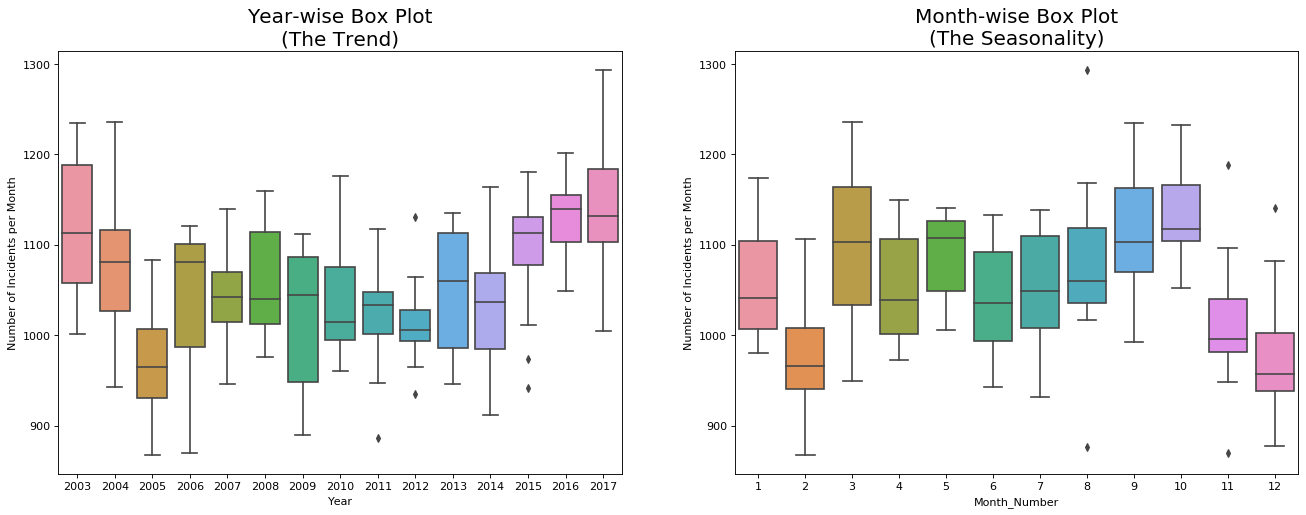

In [13]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Year', y='Number of Incidents per Month', data=monthGrouped, ax=axes[0])
sns.boxplot(x='Month_Number', y='Number of Incidents per Month', data=monthGrouped, ax=axes[1])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

## Decompose Time Series into Components

In a **multiplicative decomposition**, the trend, seasonality, and residual components can be mutliplied to get the original observations.

In an **additive decomposition**, they are added together to get the orignal observation.

###  By Week

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [15]:
# Splice relevant columns
dfDecompose = df1[['IncidntNum','Category','Year','Week_Number', "Month_Number", 'Date']]

# Select ASSAULT crimes only
dfDecompose = dfDecompose[dfDecompose['Category'] == 'ASSAULT']

# Drop records from 2018 since data from only part of the year is available
dfDecompose = dfDecompose[(dfDecompose['Year'] < 2018)]

# Group by week
weekGrouped = dfDecompose.resample('W', on='Date')[['IncidntNum']].count() #.reset_index().sort_values(by='Date')
weekGrouped.rename(columns = {'IncidntNum': "Incidents/Week"}, inplace = True)

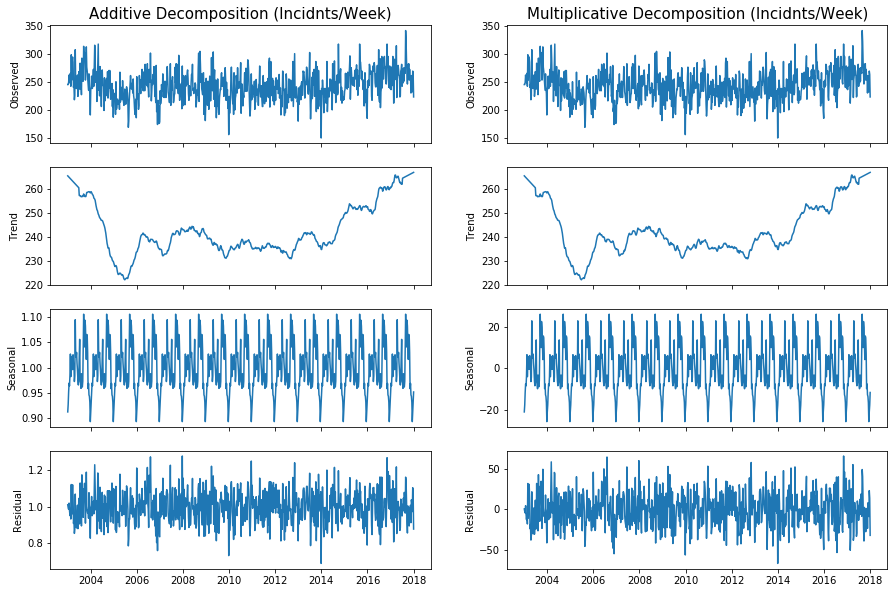

In [16]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(weekGrouped['Incidents/Week'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(weekGrouped['Incidents/Week'], model='additive', extrapolate_trend='freq')

# Create plot and set size
plt.rcParams.update({'figure.figsize': (15,10)})
f, ax = plt.subplots(nrows = 4, ncols = 2, sharex = True)

# Loop through the types of models and their index which is the column
for col, model in enumerate([result_mul, result_add]):
   
    ax[0, col].plot(model.observed)
    ax[0, col].set_ylabel('Observed')

    ax[1, col].plot(model.trend)
    ax[1, col].set_ylabel('Trend')
    
    ax[2, col].plot(model.seasonal)
    ax[2, col].set_ylabel('Seasonal')
    
    ax[3, col].plot(model.resid)
    ax[3, col].set_ylabel('Residual')

ax[0, 0].set_title("Additive Decomposition (Incidnts/Week)", fontdict = {'fontsize': 15})
ax[0, 1].set_title("Multiplicative Decomposition (Incidnts/Week)",  fontdict = {'fontsize': 15})
plt.show()


### By Month

In [17]:
# Splice relevant columns
dfDecompose = df1[['IncidntNum','Category','Year','Week_Number', "Month_Number", 'Date']]

# Select ASSAULT crimes only
dfDecompose = dfDecompose[dfDecompose['Category'] == 'ASSAULT']

# Drop records from 2018 since data from only part of the year is available
dfDecompose = dfDecompose[(dfDecompose['Year'] < 2018)]

# Group by month
monthGrouped = dfDecompose.resample('M', on='Date')[['IncidntNum']].count() #.reset_index().sort_values(by='Date')
monthGrouped.rename(columns = {'IncidntNum': "Incidents/Month"}, inplace = True)

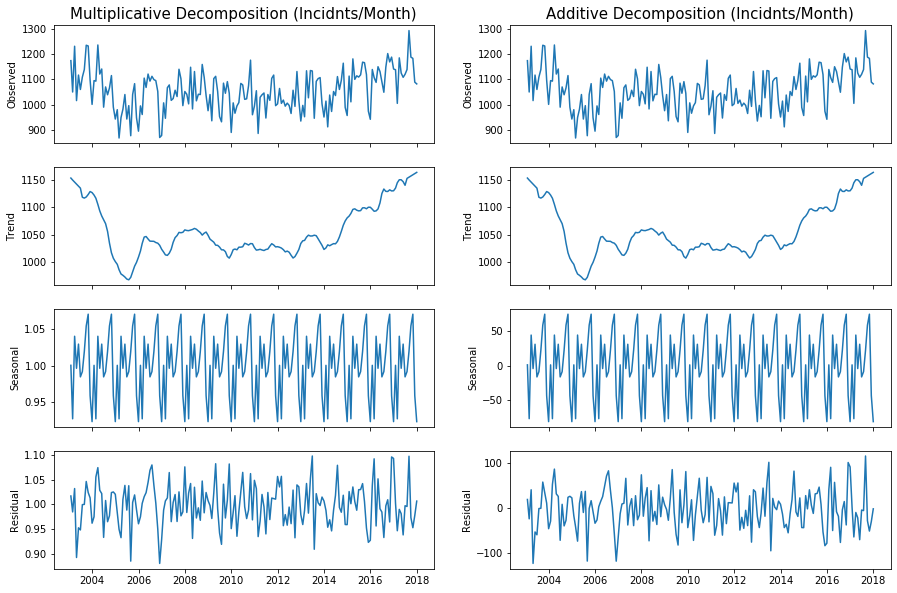

In [18]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(monthGrouped['Incidents/Month'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(monthGrouped['Incidents/Month'], model='additive', extrapolate_trend='freq')

# Create plot and set size
plt.rcParams.update({'figure.figsize': (15,10)})
f, ax = plt.subplots(nrows = 4, ncols = 2, sharex = True)

# Loop through the types of models and their index which is the column
for col, model in enumerate([result_mul, result_add]):
   
    ax[0, col].plot(model.observed)
    ax[0, col].set_ylabel('Observed')

    ax[1, col].plot(model.trend)
    ax[1, col].set_ylabel('Trend')
    
    ax[2, col].plot(model.seasonal)
    ax[2, col].set_ylabel('Seasonal')
    
    ax[3, col].plot(model.resid)
    ax[3, col].set_ylabel('Residual')

ax[0, 0].set_title("Multiplicative Decomposition (Incidnts/Month)",  fontdict = {'fontsize': 15})
ax[0, 1].set_title("Additive Decomposition (Incidnts/Month)", fontdict = {'fontsize': 15})
plt.show()

In [19]:
# Combine seasonality, trend, residual to make an new dataframe
df_multDecompose = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_multDecompose.columns = ['seas', 'trend', 'resid', 'actual_values']
df_multDecompose.head()

df_addDecompose = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_addDecompose.columns = ['seas', 'trend', 'resid', 'actual_values']
df_addDecompose.head()

,seas,trend,resid,actual_values
Date,,,,
2003-01-31,1.014341,1153.616696,19.368964,1174.0
2003-02-28,-76.450442,1149.921766,-23.471324,1050.0
2003-03-31,43.898665,1146.226836,40.874500,1231.0
2003-04-30,-4.321673,1142.531906,-122.210232,1016.0
2003-05-31,30.682989,1138.836976,-52.519964,1117.0


## Should a seasonal or standard ARIMA model be used?

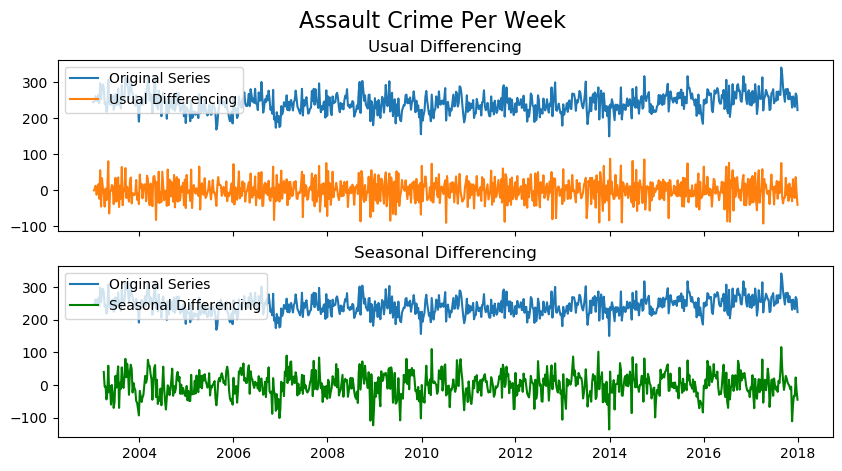

In [20]:
# Import
data = weekGrouped

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Assault Crime Per Week', fontsize=16)
plt.show()

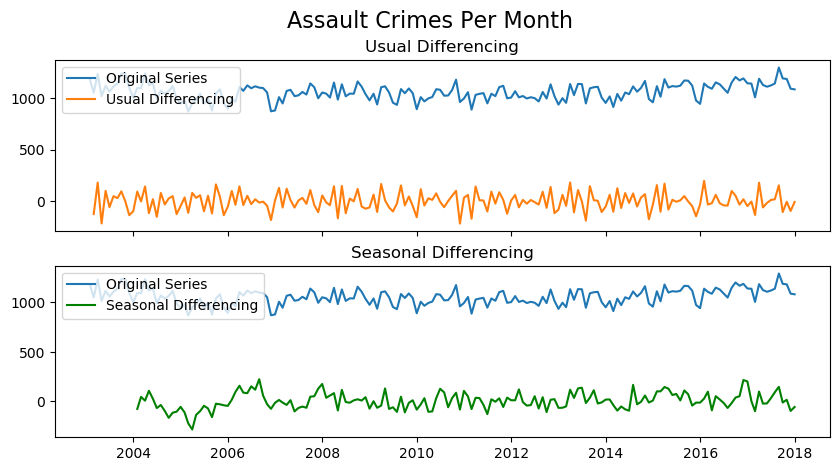

In [21]:
# Import
data = monthGrouped

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Assault Crimes Per Month', fontsize=16)
plt.show()

Seasonality differencing does not seem to smooth out the time series. Therefore it seems that assault crimes do not exhibit very strong seasonality and a nonseasonal model may be sufficient.